In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy
import numpy as np
import random

      
class BatchDataGenerator():
    
    def __init__(self, batch_parameters):
        self.batch_parameters = batch_parameters
        
    
    def read_data(self):
        
        def parse_data(filename):
            with open(filename, "rb") as f:
                infoline = f.readline()
                infoline = re.sub(r"^b'", "", str(infoline))
                n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
                features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
            mlb = MultiLabelBinarizer()
            labels = mlb.fit_transform(labels)
            features = np.array(features.todense())
            features = np.ascontiguousarray(features)
            return features, labels

        X, y = parse_data("Bibtex_data.txt")
        self.data = X
        self.labels = y
        self.data_length = len(X)
        
        
    def get_batch(self):

        curr = 0
        total_size = self.data_length
        DONE_FLAG = True

        while( curr < total_size ):
            start = curr
            end = (curr + self.batch_parameters['batch_size'])%total_size

            #print("Current ",start,end)
            if((end < start) and self.batch_parameters['WRAP_AROUND'] == True):
                size_to_end = total_size - curr
                size_leftover = self.batch_parameters['batch_size'] - size_to_end
                data_chunk_to_end = self.data[curr:]
                data_chunk_leftover = self.data[0:end]
                data_return = data_chunk_to_end + data_chunk_leftover
                labels_chunk_to_end = self.labels[curr:]
                labels_chunk_leftover = self.labels[curr:]
                labels_return = labels_chunk_to_end + labels_chunk_leftover
                yield(data_return, labels_return)
            elif((end < start) and (( self.batch_parameters['RUN_TILL_END_RESTART'] == True) or (self.batch_parameters['RUN_TILL_END_AND_STOP'] == True))):
                print("Getting to the end")
                DONE_FLAG = True
                yield(self.data[curr:], self.labels[curr:])
            else:
                yield(self.data[start: end], self.labels[start: end])

            if(self.batch_parameters['RUN_TILL_END_RESTART'] == True):
                    curr = (curr + self.batch_parameters['batch_size'])
                    if(curr > total_size):
                        curr = 0
            if(self.batch_parameters['RUN_TILL_END_AND_STOP'] == True):
                    curr = curr + self.batch_parameters['batch_size']
            if(batch_parameters['WRAP_AROUND'] == True):
                curr = (curr + self.batch_parameters['batch_size'])%total_size
                
                
class ContextualDeterministicEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward = 1
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        if(self.context_action_mapping[str(context)] == action):
            return self.reward
        else:
            return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

In [2]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

# batch size - algorithms will be refit after N rounds
batch_size = 50

batch_parameters = {'batch_size': batch_size, 'RUN_TILL_END_AND_STOP': True, 'RUN_TILL_END_RESTART':False, 'WRAP_AROUND': False}
data_obj = BatchDataGenerator(batch_parameters)
data_obj.read_data()
data_iter = data_obj.get_batch()
data = next(data_iter)

nchoices = data[1].shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Important!!! the default values for beta_prior will be changed in version 0.3

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = 2222)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = 3333)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = 4444)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = 5555)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = 6666)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = 7777)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = 8888)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = 9999)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = 1234)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = 5678)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, logistic_ucb, adaptive_greedy_perc]

#          adaptive_greedy_thr,  explore_first, active_explorer,adaptive_active_greedy, softmax_explorer]

In [6]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb, \
rewards_agr = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb, rewards_agr]

X_total = np.empty((0, data[0].shape[1]), float)
y_total = np.empty((0, data[1].shape[1]), float)

# initial seed - all policies start with the same small random selection of actions/rewards
batch_parameters = {'batch_size': batch_size, 'RUN_TILL_END_AND_STOP': True, 'RUN_TILL_END_RESTART':False, 'WRAP_AROUND': False}
data_obj = BatchDataGenerator(batch_parameters)
data_obj.read_data()
data_iter = data_obj.get_batch()
data = next(data_iter)

first_batch, y_batch = data
print(first_batch.shape)
print(y_batch.shape)
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = np.array([elem[action] for elem,action in zip(y_batch, action_chosen)])
print(rewards_received)
print(action_chosen.shape)
print(rewards_received.shape)

X_total = np.vstack([X_total, first_batch])
y_total = np.vstack([y_total, y_batch])

print(first_batch.shape, action_chosen.shape, rewards_received.shape)
# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

(50, 1836)
(50, 159)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
(50,)
(50,)
(50, 1836) (50,) (50,)


In [4]:
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr]

## rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_batch, y_batch ):
    np.random.seed(1)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')

    #print("Actions ", actions_this_batch)
    
    ## adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    ## Get the rewards for all actions from the array new_actions_hist
    y_total_selected_rewards = np.array([elem[action] for elem, action in zip(y_total, new_actions_hist)])
    
    ## keeping track of the sum of rewards received
    current_selected_rewards = np.array([elem[action] for elem, action in zip(y_batch, actions_this_batch)])
    rewards.append(current_selected_rewards.sum())
    
    print("New actions hist ",sum(new_actions_hist), len(new_actions_hist), sum(rewards))
    
    model.fit(X_total, new_actions_hist, y_total_selected_rewards, warm_start = True)
    
    return new_actions_hist


ct = 0
# now running all the simulation
for elem in iter(data_iter):
    ct += 1
    print(ct)
    X_batch, y_batch = elem
    X_total = np.vstack([X_total, X_batch])
    y_total = np.vstack([y_total, y_batch])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X_batch, y_batch)
        
        
        

1
New actions hist  7721 100 1
New actions hist  8515 100 1
New actions hist  7621 100 2
New actions hist  8448 100 0
New actions hist  8295 100 1
New actions hist  8037 100 0
2
New actions hist  12132 150 2
New actions hist  12583 150 1
New actions hist  11775 150 2
New actions hist  12436 150 0
New actions hist  12403 150 3
New actions hist  11446 150 0
3
New actions hist  15961 200 2
New actions hist  16306 200 1
New actions hist  15757 200 3
New actions hist  15746 200 2
New actions hist  16097 200 4
New actions hist  15247 200 0
4
New actions hist  19675 250 3
New actions hist  19568 250 2
New actions hist  18748 250 5
New actions hist  21029 250 2
New actions hist  20000 250 5
New actions hist  19286 250 1
5
New actions hist  23289 300 5
New actions hist  23551 300 4
New actions hist  23057 300 5
New actions hist  25072 300 2
New actions hist  24570 300 6
New actions hist  24509 300 3
6
New actions hist  27163 350 5
New actions hist  27838 350 6
New actions hist  27484 350 5
New 

New actions hist  180733 2200 170
New actions hist  164573 2200 63
New actions hist  163677 2200 111
New actions hist  188421 2200 300
New actions hist  176049 2200 152
44
New actions hist  200010 2250 230
New actions hist  185000 2250 173
New actions hist  168115 2250 71
New actions hist  167160 2250 120
New actions hist  192647 2250 314
New actions hist  180195 2250 160
45
New actions hist  204605 2300 238
New actions hist  189900 2300 175
New actions hist  170962 2300 81
New actions hist  170501 2300 126
New actions hist  196563 2300 326
New actions hist  184408 2300 168
46
New actions hist  209372 2350 246
New actions hist  193610 2350 178
New actions hist  173958 2350 87
New actions hist  173534 2350 131
New actions hist  201733 2350 335
New actions hist  187481 2350 178
47
New actions hist  214057 2400 259
New actions hist  197782 2400 183
New actions hist  177636 2400 92
New actions hist  176923 2400 135
New actions hist  206692 2400 352
New actions hist  192273 2400 190
48
New 

New actions hist  341809 4150 556
83
New actions hist  378792 4200 782
New actions hist  346985 4200 382
New actions hist  305126 4200 666
New actions hist  310163 4200 548
New actions hist  358775 4200 879
New actions hist  346467 4200 573
84
New actions hist  383509 4250 800
New actions hist  351027 4250 390
New actions hist  308656 4250 687
New actions hist  313745 4250 565
New actions hist  362856 4250 896
New actions hist  351334 4250 587
85
New actions hist  387523 4300 815
New actions hist  354589 4300 393
New actions hist  312158 4300 706
New actions hist  317327 4300 581
New actions hist  366871 4300 910
New actions hist  355277 4300 599
86
New actions hist  391923 4350 829
New actions hist  358526 4350 396
New actions hist  316000 4350 724
New actions hist  320792 4350 594
New actions hist  370856 4350 924
New actions hist  358544 4350 608
87
New actions hist  397579 4400 852
New actions hist  362872 4400 405
New actions hist  319997 4400 746
New actions hist  325323 4400 617

122
New actions hist  555042 6150 1459
New actions hist  506631 6150 649
New actions hist  438687 6150 1344
New actions hist  456153 6150 1146
New actions hist  529176 6150 1481
New actions hist  493344 6150 1205
123
New actions hist  559047 6200 1476
New actions hist  510269 6200 659
New actions hist  440973 6200 1360
New actions hist  459912 6200 1161
New actions hist  532677 6200 1499
New actions hist  496857 6200 1221
124
New actions hist  563513 6250 1492
New actions hist  514948 6250 665
New actions hist  444201 6250 1377
New actions hist  464404 6250 1177
New actions hist  537188 6250 1515
New actions hist  500638 6250 1237
125
New actions hist  567764 6300 1506
New actions hist  519314 6300 672
New actions hist  447832 6300 1391
New actions hist  468061 6300 1191
New actions hist  541326 6300 1528
New actions hist  504795 6300 1252
126
New actions hist  571229 6350 1522
New actions hist  523626 6350 678
New actions hist  451319 6350 1409
New actions hist  471475 6350 1206
New a

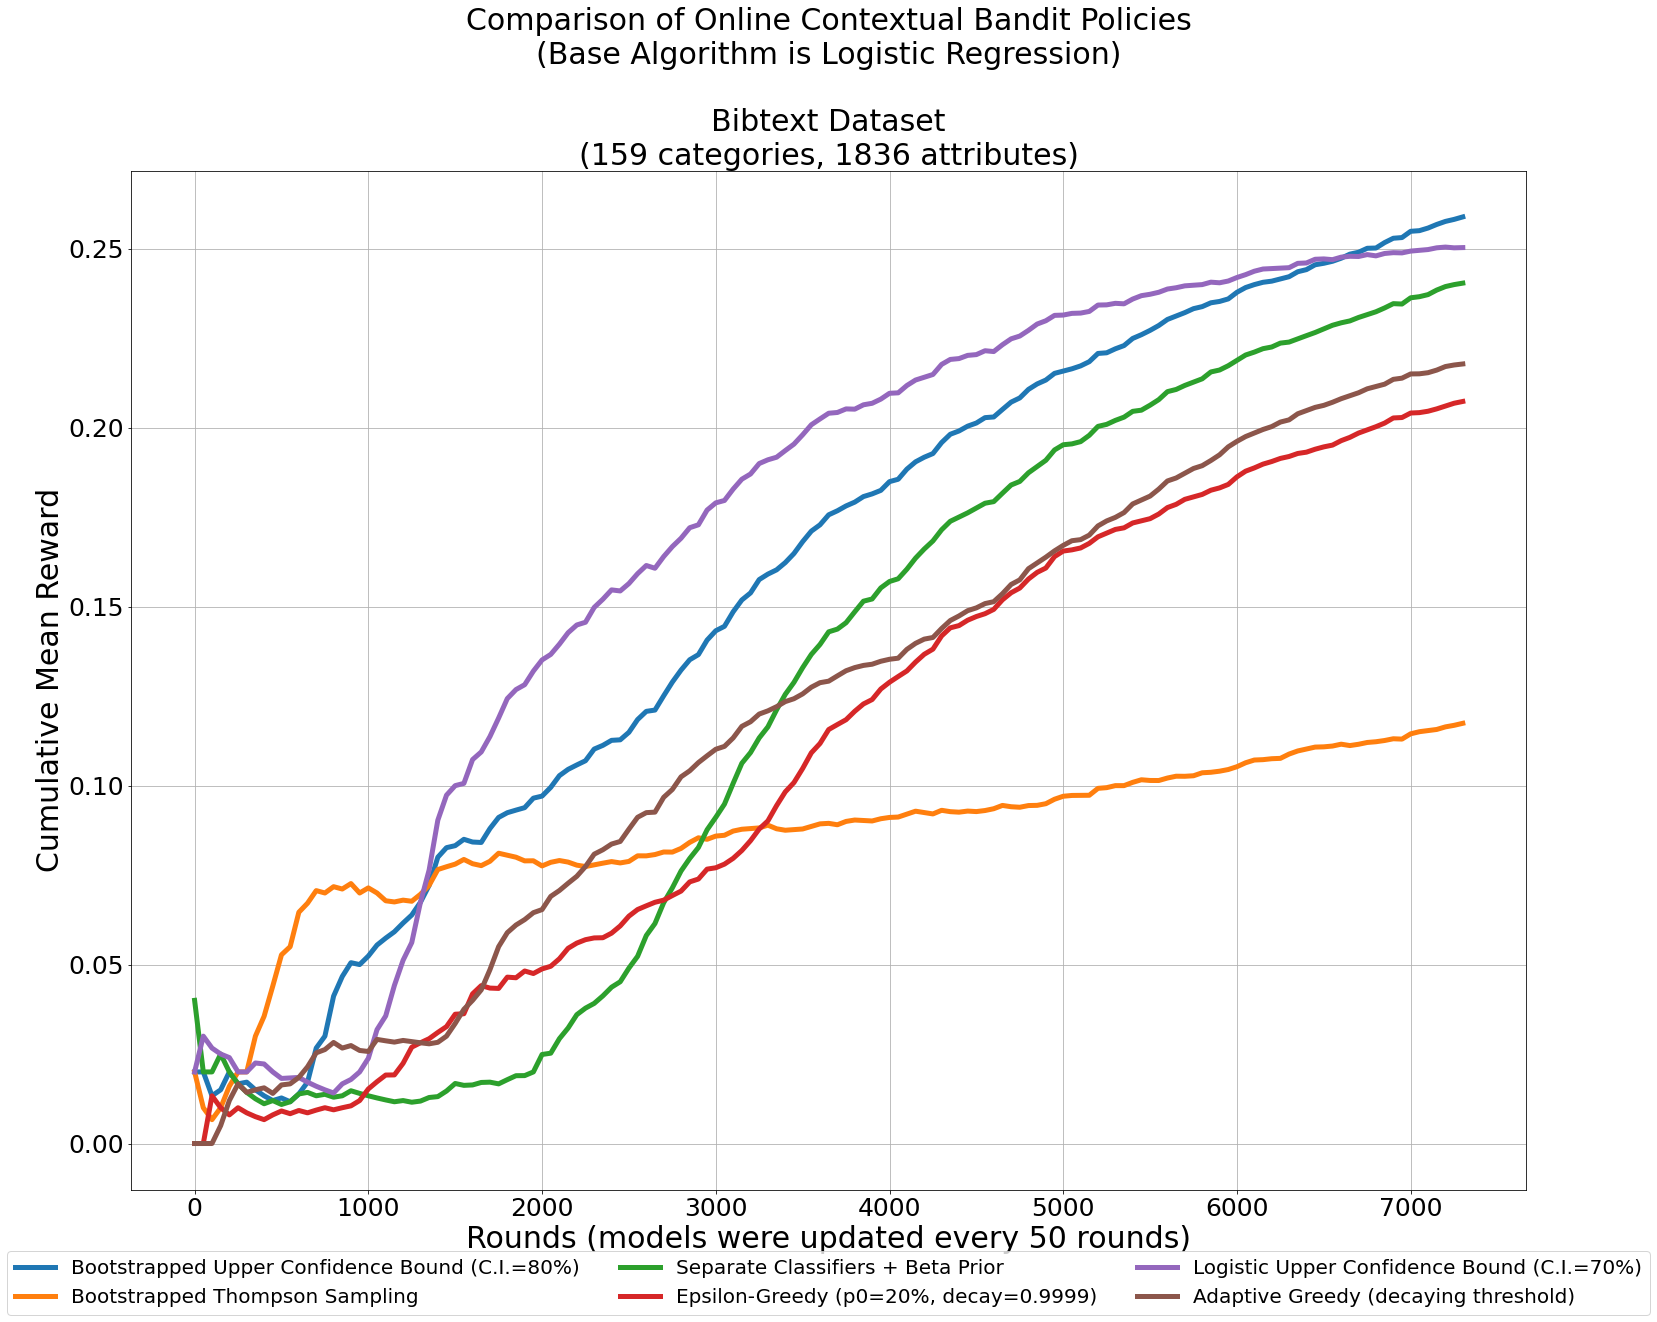

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()